# How to implement NN in DyNet
Original source: Yoav Goldberg talk on Pycon Israel 2017 (https://youtu.be/8eYZz6kiuUA)

## Computation Graphs
Example network: MLP (Multi-Layer Perceptron)<br/>
Two linear layers + tanh function, which can be expressed as a graph:
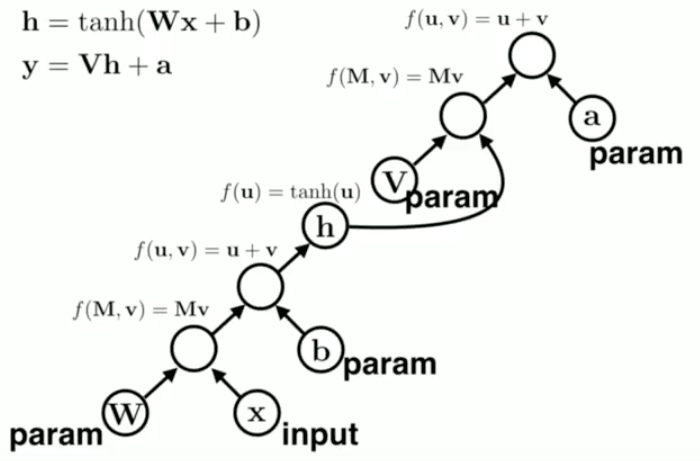
<br/>
### Training a Neural Network
Once we have this graph, we can **train** it: run **forward** to get values, and **backward** to get gradients.

## The Python NN toolkits
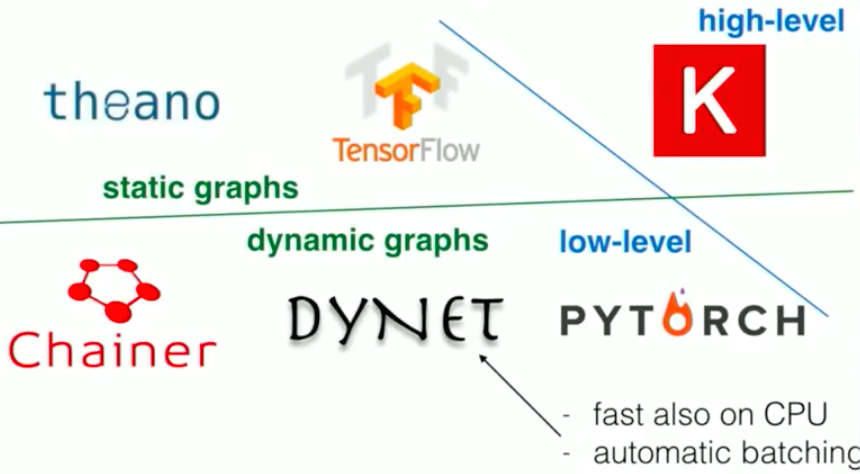

### Static frameworks (TF, Theano)
- Use a DSL (Domain Specific Language) for defining the graph
- Feed examples through the graph

### Dynamic Frameworks (DyNet, PyTorch)
- Use Python for creating the graph
- Build a graph for each example
    - Crucial when different examples have different structures, i.e. RNN where every sequence has different length
    - In TF and other frameworks we'd have to use workaraounds, like padding

### DyNet
- c++ code
- **Python wrapper**

## Buidling Computation Graphs in DyNet

### The major players
- **Computation Graph**. The graph itself. Implicit. Singleton
- **Expressions**. Nodes in the graph
- **Parameters**. The thing we are optimizing over ;)
    - vectors, matrices
    - they **out-live** the computation graph: when we create a new graph, everything dies but the parameters persist
- **Model**. A collection of parameters
- **Trainer**. Updates the parameters according to the gradients and some rules
    - SGD, Adam, ...

### Expressions

In [1]:
import dynet as dy

# create a new computation graph
dy.renew_cg()

# create expressions and combine them with operators
# v1...v6 are nodes in the graph; they represent simbolic computations (they don't actually compute anything)
v1 = dy.inputVector([1, 2, 3, 4])
v2 = dy.inputVector([5, 6, 7, 8])
v3 = v1 + v2
v4 = v3 * 2
v5 = v1 + 1
v6 = dy.concatenate([v1, v2, v3, v5])

# v1 ... v6 are expression objects
print(v6)
    

expression 5/1


In [2]:
# forward computation: get the actual value of the computation
# we can use: .value(), .npvalue(), .scalar_value(), .vec_value(), .forward()
print(v6.value())
print(v6.npvalue())
# print(v6.scalar_value())
print(v6.vec_value())
print(v6.forward())  # if we don't need the result, i.e., we are training

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 6.0, 8.0, 10.0, 12.0, 2.0, 3.0, 4.0, 5.0]
[ 1.  2.  3.  4.  5.  6.  7.  8.  6.  8. 10. 12.  2.  3.  4.  5.]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 6.0, 8.0, 10.0, 12.0, 2.0, 3.0, 4.0, 5.0]
None


### Model and Parameters

In [3]:
model = dy.Model()

W = model.add_parameters((20, 4))
b = model.add_parameters(20)

dy.renew_cg()

x = dy.inputVector([1, 2, 3, 4])

# combine expressions to create another expression
y = W * x + b

print (y.value())

[-0.4490709602832794, -0.3421028256416321, 0.9912776947021484, -0.6749377846717834, 0.7490682601928711, 0.09221869707107544, 1.92910635471344, 0.4709186255931854, -0.7944316267967224, -2.8784985542297363, -1.7579476833343506, -1.0635358095169067, -0.8814093470573425, 0.44045478105545044, 0.45293599367141724, 0.6526778936386108, 1.8079174757003784, -1.7702655792236328, 0.29807308316230774, -0.5500245690345764]


### Parameters Initialization

In [4]:
import numpy as np
model = dy.Model()

pW = model.add_parameters((4, 4))
pW2 = model.add_parameters((4, 4), init=dy.GlorotInitializer())
pW3 = model.add_parameters((4, 4), init=dy.NormalInitializer(0, 1))
pW4 = model.parameters_from_numpy(np.eye(4))

In [5]:
print(pW.value())
print(pW2.value())
print(pW3.value())
print(pW4.value())

[[-0.81865627  0.55511993 -0.25721675  0.8486594 ]
 [-0.68881607  0.66240925 -0.26505166  0.33445534]
 [ 0.71998537 -0.01446616  0.8621009  -0.72389054]
 [ 0.03661758  0.29135245 -0.37533364  0.70668423]]
[[-0.30367005  0.82097757  0.39173216 -0.62812018]
 [-0.47056898  0.47210336 -0.54505509  0.34365037]
 [ 0.53009588  0.3843118   0.47327501  0.60428625]
 [ 0.73489761 -0.4463892  -0.23249191 -0.07538898]]
[[-1.5778662   1.16269493  0.16453715 -0.49895695]
 [ 1.86446333  0.71598035  1.93165624 -0.60498708]
 [ 0.56118518  0.2539036   0.23773411 -0.46163753]
 [-1.18606627 -1.54859781 -0.6857686  -0.25042865]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


### Trainers and Backdrop

- Initialize a **Trainer** with a given model
    - there are different trainers: SimpleSGDTrainer, MomentumSGDTrainer, AdagradTrainer, **AdamTrainer**...
- Compute **gradients** by calling _expr.backward()_ from a scalar node
- **update the model parameters** using the gradients calling _Trainer.update()_

Silly example: we want to minimize the dot product

In [6]:
# create model, add parameters and create Trainer
model = dy.Model()
v = model.add_parameters(10)
trainer = dy.SimpleSGDTrainer(model)

# This loop will optimize v such that its dot product with itself will be low
# For each training example:
#    - create computation graph
#    - run forward (compute the loss)
#    - run backward (compute the gradients)
#    - update parameters
for i in range(10):
    dy.renew_cg()
    # DEPRECATED. There is no longer need to explicitly add parameters to the computation graph. 
    # Any used parameter will be added automatically.
    # v = dy.parameter(p_v)
    v2 = dy.dot_product(v, v)

    v2.forward()
    v2.backward()

    trainer.update()
    
    # check value of dot product to see that it decreases with each iteration
    print(dy.dot_product(v, v).value())

0.8930057287216187
0.5715236663818359
0.36577513813972473
0.23409609496593475
0.14982149004936218
0.0958857610821724
0.061366885900497437
0.03927480801939964
0.02513587474822998
0.016086960211396217


### Example: MLP for XOR Problem
Linear models can not model the XOR problem, but NN can!

We model it as the sigmoid over the MLP, and this is the mathematical notation:
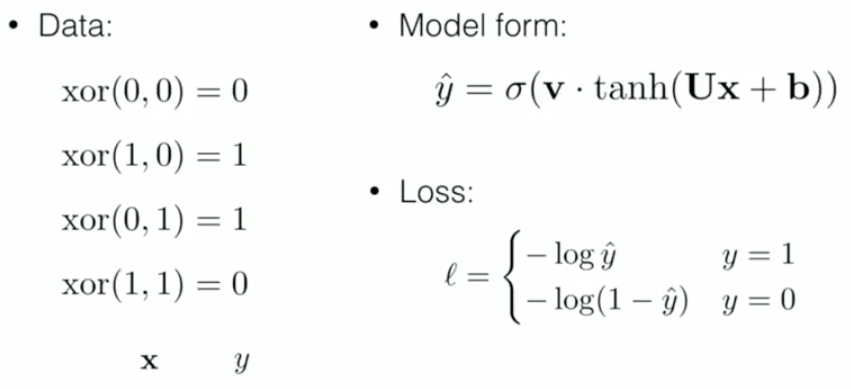

In [20]:
import dynet as dy
import random


def predict(expr):
    # U = dy.parameter(pU)  ## deprecated
    # b = dy.parameter(pb)  ## deprecated
    # v = dy.parameter(pv)  ## deprecated
    
    y = dy.logistic(dy.dot_product(v, dy.tanh(U * expr + b)))
    
    return y


def compute_loss(expr, y):
    if y == 0:
        return -dy.log(1 - expr)
    elif y == 1:
        return -dy.log(expr)

        
data = [([0, 1], 1),
        ([1, 0], 1),
        ([0, 0], 0),
        ([1, 1], 0)]

model = dy.Model()
U = model.add_parameters((4, 2))
b = model.add_parameters(4)
v = model.add_parameters(4)

trainer = dy.SimpleSGDTrainer(model)
closs = 0.0

for iter in range(1000):
    random.shuffle(data)
    for x, y in data:
        dy.renew_cg()  ## create a new graph for each example

        x = dy.inputVector(x)
        yhat = predict(x)

        loss = compute_loss(yhat, y)

        closs += loss.scalar_value()  # forward
        loss.backward()
        trainer.update()

        if iter > 0 and iter % 100 == 0:
            print('Iter: ', iter, '\t loss: ', closs/400)
            closs = 0



Iter:  100 	 loss:  0.6802889417856932
Iter:  100 	 loss:  0.0014541205763816834
Iter:  100 	 loss:  0.0014767201244831084
Iter:  100 	 loss:  0.0010148397833108901
Iter:  200 	 loss:  0.24823509666137397
Iter:  200 	 loss:  0.00010954492725431919
Iter:  200 	 loss:  0.0002645605988800526
Iter:  200 	 loss:  0.00021419849246740342
Iter:  300 	 loss:  0.04722268860321492
Iter:  300 	 loss:  7.320125121623277e-05
Iter:  300 	 loss:  8.761043660342694e-05
Iter:  300 	 loss:  4.344700835645199e-05
Iter:  400 	 loss:  0.020951854530721903
Iter:  400 	 loss:  2.4766107089817523e-05
Iter:  400 	 loss:  4.077970050275326e-05
Iter:  400 	 loss:  4.936430603265762e-05
Iter:  500 	 loss:  0.012971740124048664
Iter:  500 	 loss:  2.73900106549263e-05
Iter:  500 	 loss:  1.7486880533397198e-05
Iter:  500 	 loss:  3.326303558424115e-05
Iter:  600 	 loss:  0.009265373236266895
Iter:  600 	 loss:  1.345553551800549e-05
Iter:  600 	 loss:  2.4670995771884917e-05
Iter:  600 	 loss:  2.2578563075512648e-

## Word Embeddings and LookupParameters

In NLP, it is very common to use **feature embeddings**: you map discrete features (i.e. a word) to some numerical vector, and this vector is a parameter of the model that is being trained.

- each feature is represented as a **d-dim vector**
- vectors are **combined** (concatenation, addition...) to form an **input vector**
- embeddings can be **pre-trained**
- embeddings are usually **trained with the model**
    - feature vectors are **parameters of the model** and are trained jointly with the rest of the network
- **Representation Learning**: similar features will receive similar vectors

TODO: add image from MCV thesis to illustrate

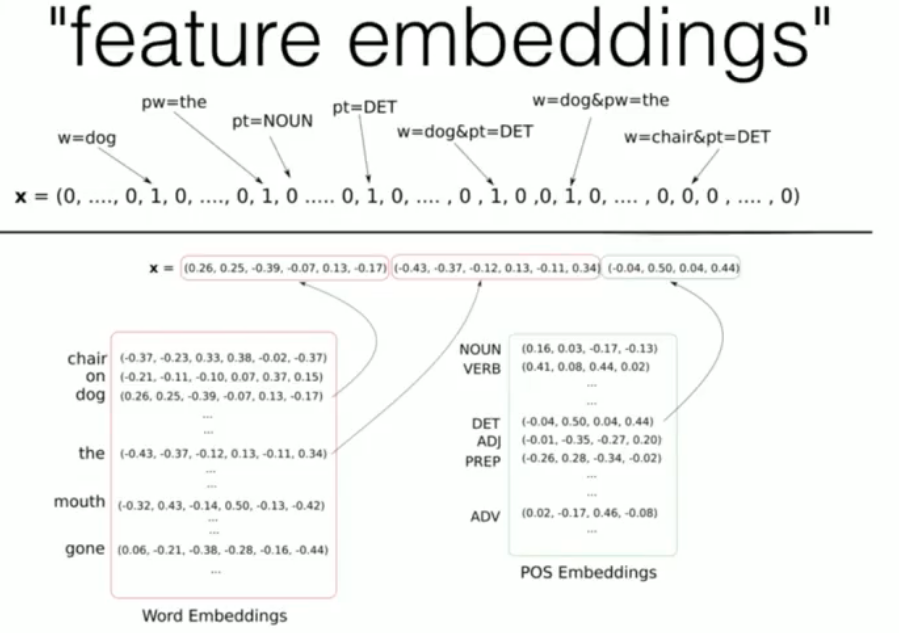

In DyNet, embeddings are implemented using **LookupParameters**. Example:

In [24]:
vocab_size = 10000
emb_dim = 200

E = model.add_lookup_parameters((vocab_size, emb_dim))  ## 10000 entries; each entry is a 200 dimensional vector

dy.renew_cg()

x = dy.lookup(E, 5)  ## example: look at the 5yh entry
# or
x = E[5]  ## more pythonic way ;)

print(x)  # x is an expression

expression 1/32024


How many dimensions? between 50 and 300 is usually good; smaller --> faster, bigger --> slower, you have to guess